In [ ]:
!wget https://www.dropbox.com/s/nd7v1fod89xla6j/vk_texts_with_sources.csv

In [1]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

### Задание 1. Описательные статистики

In [3]:
import pandas as pd
import numpy as np
from itertools import chain

In [3]:
import re

In [29]:
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
punct = punctuation+'«»—…“”*№–'

[nltk_data] Downloading package stopwords to /home/lisa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data = pd.read_csv('vk_texts_with_sources.csv', index_col=['Unnamed: 0'])
data.head()

,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


выкинем пустые строчки

In [6]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

Посчитаем количество классов и количество текстов в каждом

In [7]:
data.groupby('source').count() 

,text
source,
mchsgov,3024
mil,3017
mospolice,2854
russianpost,2631


Всего текстов:

In [8]:
data.count()

text      11526
source    11526
dtype: int64

Очистим тексты от ```<br>```

In [7]:
def clean(text):    
    text = re.sub('<br>', '', text)
    return text

In [8]:
data['clean_text'] = data['text'].apply(clean)

In [11]:
data.head()

,text,source,clean_text
0,Начальник Главного оперативного управления Ген...,mil,Начальник Главного оперативного управления Ген...
1,Артиллерийские подразделения общевойскового об...,mil,Артиллерийские подразделения общевойскового об...
2,Подразделения морской пехоты Каспийской флотил...,mil,Подразделения морской пехоты Каспийской флотил...
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,Команды на всеармейских этапах конкурсов АрМИ-...
4,На большом учебно-методическом командирском сб...,mil,На большом учебно-методическом командирском сб...


Средняя длина текста в символах

In [9]:
data['char_len'] = data['clean_text'].str.len()

In [13]:
data['char_len'].mean()

667.2919486378622

In [10]:
def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split() if word != '']
    words = [word for word in words if word]

    return words

In [11]:
data['tokenized'] = data['clean_text'].apply(tokenize)

In [16]:
data.head()

,text,source,clean_text,char_len,tokenized
0,Начальник Главного оперативного управления Ген...,mil,Начальник Главного оперативного управления Ген...,12874,"[начальник, главного, оперативного, управления..."
1,Артиллерийские подразделения общевойскового об...,mil,Артиллерийские подразделения общевойскового об...,735,"[артиллерийские, подразделения, общевойскового..."
2,Подразделения морской пехоты Каспийской флотил...,mil,Подразделения морской пехоты Каспийской флотил...,475,"[подразделения, морской, пехоты, каспийской, ф..."
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,Команды на всеармейских этапах конкурсов АрМИ-...,1059,"[команды, на, всеармейских, этапах, конкурсов,..."
4,На большом учебно-методическом командирском сб...,mil,На большом учебно-методическом командирском сб...,695,"[на, большом, учебно-методическом, командирско..."


Развернём всё в длинный df - по токену в строке

In [9]:
from itertools import chain
import numpy as np

In [15]:
data_long = pd.DataFrame({ "clean_text": np.repeat(data['clean_text'].values, 
                                    [len(x) for x in data['tokenized']]),
                       "source": np.repeat(data['source'].values, 
                                    [len(x) for x in data['tokenized']]),
                     "token": list(chain.from_iterable(data['tokenized']))})

In [19]:
data_long.head()

,clean_text,source,token
0,Начальник Главного оперативного управления Ген...,mil,начальник
1,Начальник Главного оперативного управления Ген...,mil,главного
2,Начальник Главного оперативного управления Ген...,mil,оперативного
3,Начальник Главного оперативного управления Ген...,mil,управления
4,Начальник Главного оперативного управления Ген...,mil,генерального


Всего слов в коллекции:

In [20]:
data_long.count()

clean_text    960802
source        960802
token         960802
dtype: int64

Удалим возможные пустые токены

In [21]:
data_long = data_long.loc[data_long['token'] != '']

In [22]:
data_long.count()

clean_text    960802
source        960802
token         960802
dtype: int64

Уникальных слов:

In [23]:
grouped_long = data_long.groupby('token')

In [24]:
len(grouped_long.count())

93417

In [13]:
data['len'] = data['tokenized'].apply(len)

Средняя длина текста в словах

In [26]:
data['len'].mean()

83.35953496442825

Добавим столбец с лемматизированными токенами

In [12]:
def lemmatize(tokens):
    
    words = [morph.parse(word)[0].normal_form for word in tokens]

    return words

In [13]:
data['lemmatized'] = data['tokenized'].apply(lemmatize)

Развернём в длинный df - теперь по лемме в строке

In [29]:
df_long = pd.DataFrame({ "text": np.repeat(data['text'].values, 
                                    [len(x) for x in data['lemmatized']]),
                       "source": np.repeat(data['source'].values, 
                                    [len(x) for x in data['lemmatized']]),
                     "lemma": list(chain.from_iterable(data['lemmatized']))})

In [30]:
df_long.head()

,text,source,lemma
0,Начальник Главного оперативного управления Ген...,mil,начальник
1,Начальник Главного оперативного управления Ген...,mil,главный
2,Начальник Главного оперативного управления Ген...,mil,оперативный
3,Начальник Главного оперативного управления Ген...,mil,управление
4,Начальник Главного оперативного управления Ген...,mil,генеральный


In [31]:
grouped = df_long.groupby('lemma')

Сколько уникальных лемм

In [32]:
len(grouped.count())

48245

Сделаем теперь датасет только с существительными

In [14]:
def noun(tokens):
    
    words = [morph.parse(word)[0] for word in tokens]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN']

    return words

In [17]:
data['noun'] = data['tokenized'].apply(noun)

In [35]:
df_long_noun = pd.DataFrame({ "text": np.repeat(data['text'].values, 
                                    [len(x) for x in data['noun']]),
                       "source": np.repeat(data['source'].values, 
                                    [len(x) for x in data['noun']]),
                     "noun": list(chain.from_iterable(data['noun']))})

In [36]:
df_long_noun.head()

,text,source,noun
0,Начальник Главного оперативного управления Ген...,mil,начальник
1,Начальник Главного оперативного управления Ген...,mil,управление
2,Начальник Главного оперативного управления Ген...,mil,штаб
3,Начальник Главного оперативного управления Ген...,mil,сила
4,Начальник Главного оперативного управления Ген...,mil,рф


Выделим по 5 частотных существительных для каждого паблика

In [37]:
df_mil = df_long_noun[df_long_noun['source'] == 'mil']

In [38]:
df_mil['noun'].value_counts()[:5]

военный       1368
минобороны    1354
россия        1289
год           1273
оборона        914
Name: noun, dtype: int64

In [39]:
df_mchsgov = df_long_noun[df_long_noun['source'] == 'mchsgov']

In [40]:
df_mchsgov['noun'].value_counts()[:5]

мчс          3489
россия       1598
мчсроссия    1218
спасатель     613
год           508
Name: noun, dtype: int64

In [41]:
df_mospolice = df_long_noun[df_long_noun['source'] == 'mospolice']

In [42]:
df_mospolice['noun'].value_counts()[:5]

полиция    5827
год        5212
москва     4160
мвд        4154
россия     3976
Name: noun, dtype: int64

In [43]:
df_russianpost = df_long_noun[df_long_noun['source'] == 'russianpost']

In [44]:
df_russianpost['noun'].value_counts()[:5]

почта        3143
россия       2585
год          2075
отделение    1583
письмо       1452
Name: noun, dtype: int64

Разобьём коллекцию на обучающую и тестовую части

In [51]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

data = shuffle(data)

train, test = train_test_split(data, test_size=0.2)

### Описательные статистики:

- количество текстов: 11525
- количество классов: 4
- количество слов в коллекции без лемматизации: 960802 - всего
    - уникальных слов без лемматизации: 93417
    - уникальных слов с лемматизацией: 48245
- среднюю длину текста в словах: 83 
    - в символах: 667
- найдите 5 самых частых существительных в текстах каждого паблика:  
    mchsgov: мчс, россия, мчсроссия, спасатель, год  
    mil: военный, минобороны, россия, год, оборона  
    mospolice: полиция, год, москва, мвд, россия  
    russianpost: почта, россия, год, отделение, письмо  

На всякий случай сохраним данные

In [17]:
data.to_csv('ml_hw1.tsv', sep='\t')

### Задание 2. Классификация по правилам

Возьмём самые частотные существительные:
1. Если в тексте встречается слово "мчс", то он относится к mchsgov
2. Если в тексте встречается слово "военный", то он относится к mil
3. Если в тексте встречается слово "полиция", то он относится к mospolice
4. Если в тексте встречается слово "почта", то он относится к russianpost

Чтобы не смотреть разные формы слов, будем смотреть лемматизированные тексты

In [262]:
def rule_classifier(text):
    words = {'мчс':'mchsgov','военный':'mil','полиция':'mospolice','почта':'russianpost'}
    source = 'none'
    for i in words:
        if i in text:
            source = words[i]
            break
    return source

In [263]:
data.lemmatized.apply(rule_classifier).head(10)

1776            none
8278            none
9934       mospolice
158             none
1856             mil
2959             mil
7591     russianpost
1025            none
11444           none
6971            none
Name: lemmatized, dtype: object

Кажется, получается плохо, добавим менее частотные дифференцирующие слова из топа

In [264]:
def rule_classifier(text):
    words = {'мчс':'mchsgov','мчсроссия':'mchsgov','военный':'mil','минобороны':'mil','полиция':'mospolice','мвд':'mospolice','почта':'russianpost','письмо':'russianpost'}
    source = 'none'
    for i in words:
        if i in text:
            source = words[i]
            break
    return source

In [265]:
data.lemmatized.apply(rule_classifier).head(10)

1776            none
8278     russianpost
9934       mospolice
158             none
1856             mil
2959             mil
7591     russianpost
1025             mil
11444      mospolice
6971            none
Name: lemmatized, dtype: object

Оценим результат работы правиловой системы

In [266]:
def evaluate(true_source, predicted_source):
    print("Precision: {0:6.2f}".format(precision_score(true_source, predicted_source, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(true_source, predicted_source, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(true_source, predicted_source, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(true_source, predicted_source)))

In [267]:
evaluate(data.source, data.lemmatized.apply(rule_classifier))

Precision:   0.77
Recall:   0.59
F1-measure:   0.66
Accuracy:   0.73


/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Проблему с текстами, которые согласно правилам классифицируются как "none" можно попробовать решить, отдельно посмотрев эти тексты и частотные слова в них и добавив в правила больше слов.

### Задание 3. Baseline

In [47]:
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Классифицируем тексты с помощью наивного байесовского классификатора. TfidfVectorizer объединяет два этапа - векторизацию (CountVectorizer) и tf−idf  взвешивание (TfidfTransformer)

In [48]:
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
classifier = MultinomialNB()

clf = Pipeline([
    ('vect', vectorizer),
    ('clf', classifier),
])

# учим классификатор
%time clf.fit(train.text, train.source)

CPU times: user 4.23 s, sys: 93 ms, total: 4.32 s
Wall time: 4.33 s


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Смотрим предсказания

In [49]:
predictions = clf.predict(test.text)

In [50]:
def metrics(original, predicted):
    print("Precision: {0:6.2f}".format(precision_score(original, predicted, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(original, predicted, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(original, predicted, average='macro')))

    print("...")

    print("Precision: {0:6.2f}".format(precision_score(original, predicted, average='micro')))
    print("Recall: {0:6.2f}".format(recall_score(original, predicted, average='micro')))
    print("F1-measure: {0:6.2f}".format(f1_score(original, predicted, average='micro')))

    print("...")

    print("Accuracy: {0:6.2f}".format(accuracy_score(original, predicted)))

In [51]:
metrics(test.source, predictions)

Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Accuracy:   0.97


In [52]:
print(classification_report(test.source, predictions))

              precision    recall  f1-score   support

     mchsgov       0.99      0.96      0.97       649
         mil       1.00      0.98      0.99       630
   mospolice       0.95      1.00      0.97       554
 russianpost       0.94      0.95      0.94       473

   micro avg       0.97      0.97      0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306



Построим матрицу ошибок

In [47]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

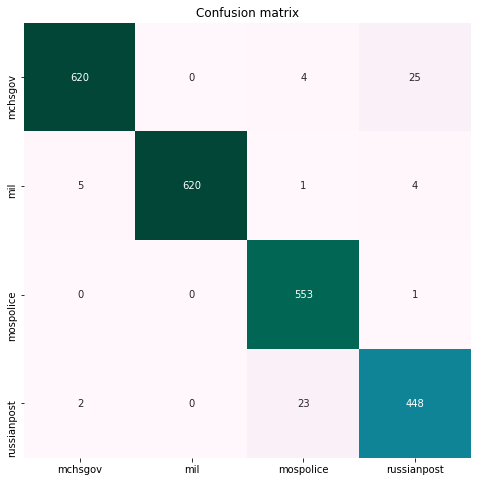

In [55]:
m = confusion_matrix(test.source, predictions)

labels = clf.classes_
plt.figure(figsize = (8,8))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Самые заметные ошибки:

25 групп из 625, относящихся к russianpost, были классифицированы как относящиеся к mchsgov.
23 группы из 520, относящихся к mospolice, были классифицированы как относящиеся к russianpost.

### Задание 4. Снижение размерности

In [56]:
from sklearn.decomposition import TruncatedSVD

In [57]:
from sklearn.linear_model import SGDClassifier

Снижение размерности производим при помощи (TruncatedSVD) LSA. Наивный Байесовский классификатор нельзя применить, так как он не берёт на вход отрицательные значения, поэтому вместо него применим метод опорных векторов.

In [58]:
reducer = TruncatedSVD(n_components=100)
classifier_dim = SGDClassifier()

clf_dim = Pipeline([
    ('vect', vectorizer),
    ('dim', reducer),
    ('clf', classifier_dim),
])

In [59]:
%time clf_dim.fit(train.text, train.source)

CPU times: user 1min 53s, sys: 2.5 s, total: 1min 55s
Wall time: 1min 56s


/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [76]:
predictions_dim = clf_dim.predict(test.text)

Посмотрим, что получилось

In [81]:
metrics(test.source, predictions_dim)

Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Accuracy:   0.97


In [77]:
print(classification_report(test.source, predictions_dim))

              precision    recall  f1-score   support

     mchsgov       0.98      0.95      0.97       614
         mil       0.99      0.97      0.98       579
   mospolice       0.96      0.99      0.98       557
 russianpost       0.93      0.96      0.95       556

   micro avg       0.97      0.97      0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306



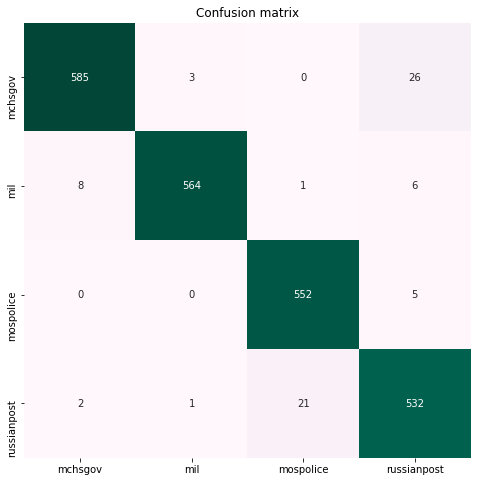

In [78]:
m_dim = confusion_matrix(test.source, predictions_dim)

labels = clf.classes_
plt.figure(figsize = (8,8))
sns.heatmap(data=m_dim, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Заметного изменения результата не произошло.  

### Задание 5. Лемматизация

Лемматизированные тексты у нас представлены списками, нужно сделать строки.

In [83]:
%time clf.fit(train.lemmatized.apply(lambda x: ' '.join(x)), train.source)

CPU times: user 3.75 s, sys: 23.2 ms, total: 3.78 s
Wall time: 3.81 s


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [85]:
predictions_lem = clf.predict(test.lemmatized.apply(lambda x: ' '.join(x)))

In [87]:
print(metrics(test.source, predictions_lem))    

Precision:   0.96
Recall:   0.96
F1-measure:   0.96
...
Precision:   0.96
Recall:   0.96
F1-measure:   0.96
...
Accuracy:   0.96
None


In [88]:
print(classification_report(test.source, predictions_lem))

              precision    recall  f1-score   support

     mchsgov       0.99      0.93      0.96       614
         mil       0.99      0.97      0.98       579
   mospolice       0.93      0.99      0.96       557
 russianpost       0.95      0.96      0.95       556

   micro avg       0.96      0.96      0.96      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.96      0.96      0.96      2306



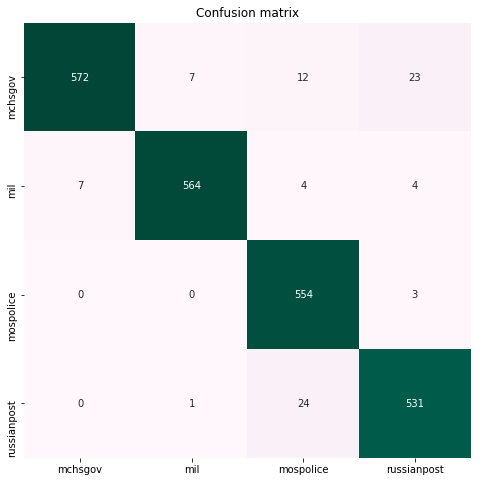

In [89]:
m = confusion_matrix(test.source, predictions_lem)

labels = clf.classes_
plt.figure(figsize = (8,8))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Я ожидала улучшение при использовани лемматизированных данных, но результат немного ухудшился.

### Задание 6. Модель скрытых тем

вот сохранённые данные и пригодились

In [4]:
data = pd.read_csv('ml_hw1.tsv', sep ='\t')

In [5]:
from ast import literal_eval
data.lemmatized = data.lemmatized.apply(literal_eval)

In [6]:
from gensim.corpora import Dictionary
texts = [data.lemmatized[i] for i in range(len(data))]

Представим данные в Gensim словарем и корпусом

In [7]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Вычислим сходства по косинусной мере на векторах tf-idf:

In [11]:
%%time
from gensim.models import *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

CPU times: user 518 ms, sys: 3.45 ms, total: 521 ms
Wall time: 528 ms


In [13]:
%%time
lsi = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=4)

CPU times: user 12.4 s, sys: 219 ms, total: 12.7 s
Wall time: 12.7 s


In [14]:
lsi.show_topics(4)

[(0,
  '0.186*"полиция" + 0.181*"мвд" + 0.179*"по" + 0.155*"москва" + 0.155*"год" + 0.153*"и" + 0.130*"россия" + 0.123*"в" + 0.119*"гу" + 0.115*"сотрудник"'),
 (1,
  '-0.499*"мчс" + -0.482*"мчсроссия" + -0.178*"советмчс" + -0.169*"безопасностьэтый" + 0.161*"мвд" + -0.158*"фактмчс" + 0.154*"полиция" + -0.141*"следовать" + -0.127*"беречь" + -0.125*"безопасность"'),
 (2,
  '-0.310*"мчсроссия" + -0.283*"мчс" + -0.196*"мвд" + -0.171*"полиция" + 0.144*"почтовый" + -0.132*"петровка38" + -0.132*"советмчс" + 0.125*"почта" + -0.123*"мвдроссия" + -0.119*"безопасностьэтый"'),
 (3,
  '0.236*"задержать" + -0.223*"утро" + -0.218*"хороший" + -0.210*"успешный" + -0.206*"добрый" + -0.202*"понедельник" + 0.197*"подозревать" + -0.188*"рабочий" + -0.183*"фото" + -0.173*"неделя"')]

In [ ]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

Попробуем LDA

In [15]:
%%time
from gensim.models import ldamodel
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

CPU times: user 36 s, sys: 10.2 ms, total: 36.1 s
Wall time: 36.2 s


In [16]:
lda.show_topics(4)

[(0,
  '0.043*"в" + 0.032*"и" + 0.022*"на" + 0.013*"с" + 0.012*"по" + 0.007*"военный" + 0.006*"быть" + 0.005*"минобороны" + 0.005*"учение" + 0.005*"из"'),
 (1,
  '0.039*"в" + 0.029*"по" + 0.022*"и" + 0.021*"полиция" + 0.017*"год" + 0.015*"на" + 0.015*"мвд" + 0.015*"москва" + 0.013*"россия" + 0.012*"с"'),
 (2,
  '0.040*"в" + 0.035*"и" + 0.019*"на" + 0.013*"с" + 0.008*"не" + 0.008*"быть" + 0.008*"почтовый" + 0.007*"из" + 0.007*"год" + 0.007*"мчс"'),
 (3,
  '0.044*"в" + 0.034*"и" + 0.016*"россия" + 0.015*"на" + 0.014*"с" + 0.012*"по" + 0.008*"почта" + 0.008*"год" + 0.007*"почтовый" + 0.007*"быть"')]

Тут особенно хорошо видно, что мы забыли почистить лемматизированный корпус от стоп-слов

In [33]:
def remove_stopwords(text, mystops = stopwords):
    text = [word for word in text if word not in stopwords.words('russian')]
    return text

In [36]:
data['cleanlemmas'] = data.lemmatized.apply(remove_stopwords)

In [38]:
texts = [data.cleanlemmas[i] for i in range(len(data))]

In [52]:
len(texts)

11526

На визуализацию такого количества текстов не хватило памяти:( Случайно выберем часть

In [53]:
import random

texts = random.sample(texts, 5000)

In [54]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [55]:
%%time
from gensim.models import *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

CPU times: user 180 ms, sys: 3.05 ms, total: 183 ms
Wall time: 182 ms


In [56]:
%%time
lsi = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=4)

CPU times: user 4.6 s, sys: 66.3 ms, total: 4.67 s
Wall time: 4.69 s


In [57]:
lsi.show_topics(4)

[(0,
  '-0.242*"мвд" + -0.240*"полиция" + -0.193*"москва" + -0.177*"год" + -0.152*"гу" + -0.147*"россия" + -0.143*"петровка38" + -0.138*"задержать" + -0.134*"сотрудник" + -0.129*"мчс"'),
 (1,
  '0.559*"мчс" + 0.507*"мчсроссия" + 0.177*"советмчс" + 0.151*"безопасностьэтый" + 0.140*"безопасность" + 0.138*"следовать" + -0.137*"мвд" + -0.128*"полиция" + 0.127*"правило" + 0.122*"фактмчс"'),
 (2,
  '0.251*"мчсроссия" + 0.224*"мчс" + 0.166*"мвд" + -0.155*"почтовый" + 0.146*"утро" + 0.138*"успешный" + -0.134*"почта" + 0.133*"фото" + 0.129*"понедельник" + 0.125*"полиция"'),
 (3,
  '-0.258*"задержать" + 0.234*"утро" + 0.224*"успешный" + -0.217*"подозревать" + 0.216*"добрый" + 0.215*"хороший" + 0.207*"понедельник" + 0.202*"рабочий" + 0.191*"неделя" + 0.186*"девушка"')]

Результат не очень хороший для классификации, хотя основные темы видно

попробуем LDA

In [60]:
%%time
from gensim.models import ldamodel
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4,
                        alpha='auto', eta='auto', iterations = 100, passes = 5)

CPU times: user 21.8 s, sys: 1.54 ms, total: 21.8 s
Wall time: 21.8 s


In [59]:
lda.show_topics(4)

[(0,
  '0.010*"год" + 0.008*"который" + 0.007*"россия" + 0.007*"свой" + 0.007*"весь" + 0.006*"это" + 0.006*"ребёнок" + 0.006*"открытка" + 0.005*"письмо" + 0.005*"наш"'),
 (1,
  '0.009*"россия" + 0.007*"военный" + 0.006*"минобороны" + 0.006*"год" + 0.005*"также" + 0.005*"который" + 0.005*"российский" + 0.004*"учение" + 0.003*"время" + 0.003*"сила"'),
 (2,
  '0.022*"полиция" + 0.022*"год" + 0.018*"россия" + 0.017*"мвд" + 0.017*"москва" + 0.010*"сотрудник" + 0.010*"гу" + 0.009*"петровка38" + 0.007*"служба" + 0.007*"начальник"'),
 (3,
  '0.016*"мчс" + 0.016*"россия" + 0.014*"почтовый" + 0.012*"почта" + 0.010*"год" + 0.008*"отделение" + 0.006*"который" + 0.006*"мчсроссия" + 0.005*"весь" + 0.005*"это"')]

В отличие от результатов применения LSI, можно выделить 4 темы, соответствующие 4 группам, из которых взяты тексты:  
 - мчс (мчс, мчсроссия, пожарный, спасатель, безопасность...)
 - почта (почтовый, почта, отделение, письмо)
 - mil (военный, минобороны)
 - полиция (полиция, увд, задержать)..
 
 Вероятно, результат можно ещё улучшить, если рассмотреть только существительные и добавить в стоп-слова "год", "Россия"

Тема - набор слов, неслучайно встретившихся в корпусе. Если у нас есть 4 темы, то они могут быть распределены по корпусу неравномерно, и тогда тексты можно классифицировать в зависимости от преобладающей темы

In [61]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2

/usr/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


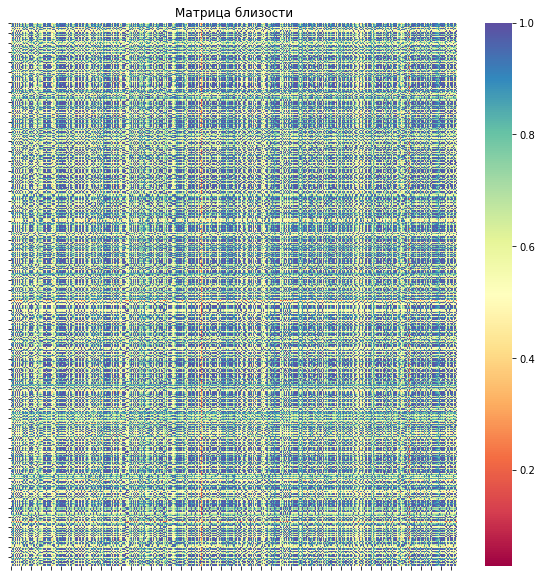

In [62]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [50]:
%who_ls

['AuthorTopicModel',
 'BackMappingTranslationMatrix',
 'CoherenceModel',
 'Dictionary',
 'Doc2Vec',
 'FastText',
 'HdpModel',
 'Image',
 'KeyedVectors',
 'LdaModel',
 'LdaMulticore',
 'LdaSeqModel',
 'LogEntropyModel',
 'LsiModel',
 'NormModel',
 'Phrases',
 'RpModel',
 'TfidfModel',
 'TranslationMatrix',
 'VocabTransform',
 'Word2Vec',
 'atmodel',
 'base_any2vec',
 'basemodel',
 'callbacks',
 'chain',
 'coherencemodel',
 'corpus',
 'corpus_lsi',
 'corpus_tfidf',
 'data',
 'deprecated',
 'dictionary',
 'display',
 'doc2vec',
 'doc2vec_inner',
 'fasttext',
 'fasttext_inner',
 'hdpmodel',
 'index',
 'interfaces',
 'keyedvectors',
 'lda',
 'ldamodel',
 'ldamulticore',
 'ldaseqmodel',
 'literal_eval',
 'logentropy_model',
 'lsi',
 'lsimodel',
 'nltk',
 'normmodel',
 'np',
 'pd',
 'phrases',
 'plt',
 'punct',
 'punctuation',
 'remove_stopwords',
 'rpmodel',
 'similarities',
 'sims',
 'sns',
 'stopwords',
 'texts',
 'tfidf',
 'tfidfmodel',
 'translation_matrix',
 'utils',
 'utils_any2vec',
 

In [31]:
del corpus_lsi, index, sims

NameError: name 'corpus_lsi' is not defined